# Laod data and prepare it
This simple example demonstrates how to plug TensorFlow Datasets (TFDS) into a Keras model.


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import math
import time
from tqdm import trange

2021-12-10 21:12:06.522999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-10 21:12:06.523039: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


5


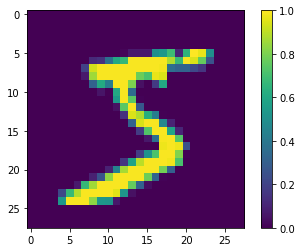

In [3]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [4]:
from scipy.ndimage.interpolation import shift

# Method to shift the image by given dimension
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image


In [5]:
idxs = np.ones(100)
for digit in range(10):
  digit_args = np.argwhere(y_train == digit)[:10,0]
  np.random.shuffle(digit_args)
  idxs[digit*10:(digit+1)*10] = digit_args
np.random.shuffle(idxs)
idxs = list(idxs.astype("int"))

In [6]:
x_train_labeled = x_train[idxs]
y_train_labeled = y_train[idxs]
x_train_unlabeled_original = np.delete(x_train.copy(), idxs, axis=0)
x_train_unlabeled = x_train_unlabeled_original[:int(x_train_unlabeled_original.shape[0]/2)] 
# Creating Augmented Dataset
# x_train_augmented = x_train_unlabeled_original[int(x_train_unlabeled_original.shape[0]/2):] 
x_train_augmented = []
for image in x_train_unlabeled:
    x_train_augmented.append(np.expand_dims(shift_image(image, 3, 3), axis=-1))
x_train_augmented = np.array(x_train_augmented)

## Seperate the unlabeled images into original and augmeneted images 

In [7]:
digit_idxs = {}
for digit in range(10):
  digit_args = np.argwhere(y_train == digit)[:,0]
  np.random.shuffle(digit_args)
  digit_idxs[digit] = list(digit_args.astype('int'))

In [8]:
elt_per_class = int(min([len(idxs) for idxs in digit_idxs.values()]) / 2)
elt_per_class

2710

In [9]:
digit_data = {}
digit_label = {}
for digit in np.unique(y_train):
  digit_data[digit] = ( x_train[ digit_idxs[digit][:elt_per_class] ] , x_train[ digit_idxs[digit][elt_per_class:elt_per_class*2] ])
  digit_label[digit] = ( y_train[ digit_idxs[digit][:elt_per_class] ] , y_train[ digit_idxs[digit][elt_per_class:elt_per_class*2] ])

In [10]:
original_data = None
original_labels = None
for digit in np.unique(y_train):
  if original_data is None:
    original_data = digit_data[digit][0]
    original_labels = digit_label[digit][0]
  else:
    original_data = np.concatenate((original_data, digit_data[digit][0]))
    original_labels = np.concatenate((original_labels, digit_label[digit][0]))

In [11]:
augmented_data = None
augmented_labels = None
for digit in np.unique(y_train):
  if augmented_data is None:
    augmented_data = digit_data[digit][1]
    augmented_labels = digit_label[digit][1]
  else:
    augmented_data = np.concatenate((augmented_data, digit_data[digit][1]))
    augmented_labels = np.concatenate((augmented_labels, digit_label[digit][1]))

In [12]:
permutation = np.random.permutation(original_data.shape[0])
augmented_data, original_data, augmented_labels, original_labels = augmented_data[permutation], original_data[permutation], augmented_labels[permutation], original_labels[permutation]

In [13]:
np.unique(np.equal(augmented_labels, original_labels))

array([ True])

In [14]:
augmented_data.shape

(27100, 28, 28, 1)

In [15]:
original_data.shape

(27100, 28, 28, 1)

4


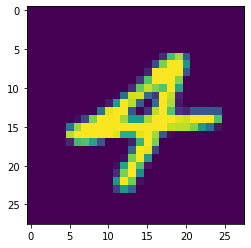

In [16]:
print(augmented_labels[0])

plt.imshow(augmented_data[0, :, :, 0])


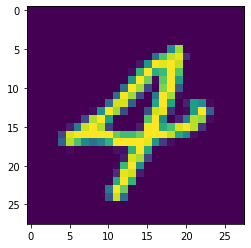

In [17]:
plt.imshow(original_data[0, :, :, 0])


# New Baseline

In [18]:
inputs = keras.Input(shape=(28,28), name="digits")
x1 = keras.layers.Dense(128, activation="relu")(inputs)
outputs = keras.layers.Dense(10, name="predictions")(x1)
model = keras.Model(inputs=inputs, outputs=outputs)

2021-12-10 21:12:18.707815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-10 21:12:18.707853: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-10 21:12:18.707882: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2021-12-10 21:12:18.708095: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
model = keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-4), 
                              # kernel_initializer=keras.initializers.he_normal
                             ),
        tf.keras.layers.Dense(10, name="classifier")
])

In [20]:
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
batch_size = 128

In [21]:
labels_per_batch=10
unlabels_per_batch=59
all_x = None
for i in range(int(100/labels_per_batch)):
    if all_x is None:
        all_x = np.concatenate((x_train_labeled[i*labels_per_batch:i*labels_per_batch+labels_per_batch], x_train_unlabeled[i*unlabels_per_batch : i*unlabels_per_batch+unlabels_per_batch], x_train_augmented[i*unlabels_per_batch: i*unlabels_per_batch+unlabels_per_batch]))
    else:
        all_x = np.concatenate((all_x,x_train_labeled[i*labels_per_batch:i*labels_per_batch+labels_per_batch], x_train_unlabeled[i*unlabels_per_batch : i*unlabels_per_batch+unlabels_per_batch], x_train_augmented[i*unlabels_per_batch: i*unlabels_per_batch+unlabels_per_batch]))

In [22]:
all_x.shape

(1280, 28, 28, 1)

In [24]:
@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

In [25]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(64)

In [26]:
epochs = 10
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step in range(math.ceil(all_x.shape[0]/batch_size)):
        x_batch_train = all_x[step*batch_size:step*batch_size+labels_per_batch]
        y_batch_train = y_train_labeled[step*labels_per_batch:step*labels_per_batch+labels_per_batch]

        # x_train_unlabeled[i*unlabels_per_batch : i*unlabels_per_batch+unlabels_per_batch]
        # x_train_augmented[i*unlabels_per_batch: i*unlabels_per_batch+unlabels_per_batch]
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch
            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits[:labels_per_batch])

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits[:labels_per_batch])

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * 64))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()


Start of epoch 0
Training loss (for one batch) at step 0: 2.2453
Seen so far: 64 samples
Training acc over epoch: 0.1500

Start of epoch 1
Training loss (for one batch) at step 0: 1.2183
Seen so far: 64 samples
Training acc over epoch: 0.8000

Start of epoch 2
Training loss (for one batch) at step 0: 0.7841
Seen so far: 64 samples
Training acc over epoch: 0.8600

Start of epoch 3
Training loss (for one batch) at step 0: 0.5240
Seen so far: 64 samples
Training acc over epoch: 0.9200

Start of epoch 4
Training loss (for one batch) at step 0: 0.3538
Seen so far: 64 samples
Training acc over epoch: 0.9500

Start of epoch 5
Training loss (for one batch) at step 0: 0.2274
Seen so far: 64 samples
Training acc over epoch: 0.9700

Start of epoch 6
Training loss (for one batch) at step 0: 0.1458
Seen so far: 64 samples
Training acc over epoch: 0.9900

Start of epoch 7
Training loss (for one batch) at step 0: 0.0988
Seen so far: 64 samples
Training acc over epoch: 1.0000

Start of epoch 8
Traini

In [27]:
for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_batch_val, training=False)
    # Update val metrics
    val_acc_metric.update_state(y_batch_val, val_logits)
val_acc = val_acc_metric.result()
val_acc_metric.reset_states()
print("Validation acc: %.4f" % (float(val_acc),))

Validation acc: 0.6991


# Research Paper Implementation

In [28]:
def _kl_divergence_with_logits(p_logits, q_logits):
  p = tf.nn.softmax(p_logits)
  log_p = tf.nn.log_softmax(p_logits)
  log_q = tf.nn.log_softmax(q_logits)

  kl = tf.reduce_sum(p * (log_p - log_q), -1)
  return kl

In [29]:
def get_ent(logits, return_mean=True):
  log_prob = tf.nn.log_softmax(logits, axis=-1)
  prob = tf.exp(log_prob)
  ent = tf.reduce_sum(-prob * log_prob, axis=-1)
  if return_mean:
    ent = tf.reduce_mean(ent)
  return ent

In [30]:
def get_tsa_threshold(schedule, global_step, num_train_steps, start, end):
    step_ratio = float(global_step) / float(num_train_steps)
    if schedule == "linear_schedule":
        coeff = step_ratio
    elif schedule == "exp_schedule":
        scale = 5
        # [exp(-5), exp(0)] = [1e-2, 1]
        coeff = tf.exp((step_ratio - 1) * scale)
    elif schedule == "log_schedule":
        scale = 5
    # [1 - exp(0), 1 - exp(-5)] = [0, 0.99]
        coeff = 1 - tf.exp((-step_ratio) * scale)
    return coeff * (end - start) + start

In [31]:
def anneal_sup_loss(sup_logits, sup_labels, sup_loss, global_step, nbr_steps, num_classes, tsa_schedule):
  tsa_start = 1. / num_classes
  eff_train_prob_threshold = get_tsa_threshold(
      tsa_schedule, global_step, nbr_steps,
      tsa_start, end=1)
  one_hot_labels = tf.one_hot(
      sup_labels, depth=num_classes, dtype=tf.float32)
  sup_probs = tf.nn.softmax(sup_logits, axis=-1)
  correct_label_probs = tf.reduce_sum(
      one_hot_labels * sup_probs, axis=-1)
  larger_than_threshold = tf.greater(
      correct_label_probs, eff_train_prob_threshold)
  loss_mask = 1 - tf.cast(larger_than_threshold, tf.float32)
  loss_mask = tf.stop_gradient(loss_mask)
  sup_loss = sup_loss * loss_mask
  avg_sup_loss = (tf.reduce_sum(sup_loss) /
                  tf.maximum(tf.reduce_sum(loss_mask), 1))
  return sup_loss, avg_sup_loss

# Model v2

In [32]:
import copy

def create_train(hyper, epochs=10, pretraining=False, verbose=False):
    
    hyper = copy.deepcopy(hyper)
    model = keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(hyper["l2"]), 
                              # kernel_initializer=keras.initializers.he_normal
                             ),
        tf.keras.layers.Dropout(hyper["dropout"]),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(hyper["l2"]), 
                              # kernel_initializer=keras.initializers.he_normal
                             ),
        tf.keras.layers.Dropout(hyper["dropout"]),
                              # kernel_initializer=keras.initializers.he_normal
                             
        tf.keras.layers.Dense(10, name="classifier")
    ])

    hyper["optimizer"] = keras.optimizers.Adam()
    hyper["loss_fn"] = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    hyper["train_acc_metric"] = keras.metrics.SparseCategoricalAccuracy()
    hyper["val_acc_metric"] = keras.metrics.SparseCategoricalAccuracy()
    
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    val_dataset = val_dataset.batch(128)
    
    if pretraining:
        print("Starting Pretraining")
        pretrain(model, x_train_labeled, y_train_labeled, val_dataset, epochs)
    print("Starting Training")
    train(model, x_train_labeled,original_data,augmented_data, val_dataset, hyper, epochs, verbose=verbose )

In [33]:
def pretrain(model, x_train, y_train,val_dataset, epochs=10, verbose=False):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    model.fit(
        x_train, y_train,
        epochs=epochs,
        validation_data=val_dataset,
        verbose=0
    )
    print("Pretraining Validation Accuracy: %.4f \n\n" % model.evaluate(val_dataset, batch_size=128)[1])

In [34]:
def train(model,x_train_labeled,original_data,augmented_data,val_dataset, hyper, epochs=10, verbose=False):
    
    @tf.function
    def test_step(x, y):
        val_logits = model(x, training=False)
        val_acc_metric.update_state(y, val_logits)
    
    unlabels_per_batch = hyper["unlabels_per_batch"]
    batch_unique_labels = hyper["batch_unique_labels"]
    labels_per_batch = hyper["labels_per_batch"]
    hyper["labels_per_batch"]
    
    optimizer = hyper["optimizer"] 
    loss_fn = hyper["loss_fn"] 
    train_acc_metric = hyper["train_acc_metric"]
    val_acc_metric = hyper["val_acc_metric"]
    tsa_schedule = hyper["tsa_schedule"]
    num_classes = hyper["num_classes"]
    uda_softmax_temp = hyper["uda_softmax_temp"]
    uda_confidence_thresh = hyper["uda_confidence_thresh"]
    ent_min_coeff = hyper["ent_min_coeff"]
    lamd = hyper["lamd"]
    
    for epoch in trange(epochs):
        if(verbose):
            print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step in range(int(original_data.shape[0]/unlabels_per_batch)):
            sup_images = x_train_labeled[int(step % batch_unique_labels)*labels_per_batch:int(step % batch_unique_labels)*labels_per_batch+labels_per_batch]
            ori_images = original_data[step*unlabels_per_batch: step*unlabels_per_batch+unlabels_per_batch]
            aug_images = augmented_data[step*unlabels_per_batch: step*unlabels_per_batch+unlabels_per_batch]

            # x_batch_train = all_x[step*batch_size:step*batch_size+batch_size]
            x_batch_train = np.concatenate((sup_images, ori_images, aug_images))
            y_batch_train = y_train_labeled[int(step % batch_unique_labels)*labels_per_batch:int(step % batch_unique_labels)*labels_per_batch+labels_per_batch]

            # x_train_unlabeled[i*unlabels_per_batch : i*unlabels_per_batch+unlabels_per_batch]
            # x_train_augmented[i*unlabels_per_batch: i*unlabels_per_batch+unlabels_per_batch]
            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:

                # Run the forward pass of the layer.
                # The operations that the layer applies
                # to its inputs are going to be recorded
                # on the GradientTape.
                logits = model(x_batch_train, training=True)  # Logits for this minibatch
                # Compute the loss value for this minibatch.
                sup_logits = logits[:labels_per_batch]
                sup_loss = loss_fn(y_batch_train, sup_logits)

                # Use TSA training loss
                if tsa_schedule:
                    sup_loss, avg_sup_loss = anneal_sup_loss(sup_logits, y_batch_train, sup_loss, epoch, epochs, num_classes, tsa_schedule)
                else:
                    avg_sup_loss = tf.reduce_mean(sup_loss)
                total_loss = avg_sup_loss

                # Get loss from the unlabled data 

                # logits of unlabled real images
                ori_logits = logits[labels_per_batch : labels_per_batch + unlabels_per_batch]
                # logits of unlabeled augmented images
                aug_logits = logits[labels_per_batch + unlabels_per_batch : ]

                #Sharpening predictions for the kl divergence
                if uda_softmax_temp != -1:
                    ori_logits_tgt = ori_logits / uda_softmax_temp
                else:
                    ori_logits_tgt = ori_logits

                # Calculate KL divergence
                aug_loss = _kl_divergence_with_logits(
                    p_logits=tf.stop_gradient(ori_logits_tgt),
                    q_logits=aug_logits)

                if uda_confidence_thresh != -1:
                    ori_prob = tf.nn.softmax(ori_logits, axis=-1)
                    largest_prob = tf.reduce_max(ori_prob, axis=-1)
                    loss_mask = tf.cast(tf.greater(
                        largest_prob, uda_confidence_thresh), tf.float32)
                    loss_mask = tf.stop_gradient(loss_mask)
                    aug_loss = aug_loss * loss_mask

                if ent_min_coeff > 0:
                    per_example_ent = get_ent(ori_logits)
                    ent_min_loss = tf.reduce_mean(per_example_ent)
                    total_loss = total_loss + ent_min_coeff * ent_min_loss
                
                avg_unsup_loss = tf.reduce_mean(aug_loss)

                total_loss += lamd * avg_unsup_loss


            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(total_loss, model.trainable_weights)

            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            # Update training metric.
            train_acc_metric.update_state(y_batch_train, logits[:labels_per_batch])

            if verbose:
                # Log every 200 batches.
                if step % 50 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(total_loss))
                    )
                    print("Seen so far: %s samples" % ((step + 1) * batch_size))

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()


        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in val_dataset:
            test_step(x_batch_val, y_batch_val)

        val_acc = val_acc_metric.result()
        val_acc_metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
        if verbose:
            print("Time taken: %.2fs \n" % (time.time() - start_time))
    return float(val_acc)


In [35]:

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(128)

In [36]:
labels_per_batch = 50
batch_size = 128

hyper = {
    "labels_per_batch":labels_per_batch,
    "batch_size" : batch_size,
    "batch_unique_labels":100/labels_per_batch,
    "unlabels_per_batch":int((batch_size-labels_per_batch)/2),
    "nbr_batch" : 100,
    "lamd" : 1,
    "tsa_schedule":"exp_schedule",
    # tsa_schedule=""
    "num_classes" : 10,
    "uda_softmax_temp" : 0.9,
    "uda_confidence_thresh" : 0.8,
    "ent_min_coeff" : 0.5,

    "num_classes" : 10,
    "decay_steps" : 1000,
    "moving_average_decay":0.9999,
    "initial_learning_rate":1e-2,
    "dropout":0.8,
    "l2": 0.1
}

In [37]:
create_train(hyper, epochs=10, pretraining=False, verbose=False)

Starting Training


  0%|          | 0/10 [00:00<?, ?it/s]

Training acc over epoch: 0.6935


 10%|█         | 1/10 [00:14<02:06, 14.03s/it]

Validation acc: 0.7488
Training acc over epoch: 0.9088


 20%|██        | 2/10 [00:28<01:52, 14.02s/it]

Validation acc: 0.7797


 30%|███       | 3/10 [00:43<01:42, 14.60s/it]

Training acc over epoch: 0.9297
Validation acc: 0.7777


 40%|████      | 4/10 [00:57<01:26, 14.49s/it]

Training acc over epoch: 0.9439
Validation acc: 0.7974


 50%|█████     | 5/10 [01:10<01:10, 14.04s/it]

Training acc over epoch: 0.9515
Validation acc: 0.8099


 60%|██████    | 6/10 [01:24<00:55, 13.78s/it]

Training acc over epoch: 0.9545
Validation acc: 0.8149


 70%|███████   | 7/10 [01:37<00:40, 13.63s/it]

Training acc over epoch: 0.9593
Validation acc: 0.8277


 80%|████████  | 8/10 [01:51<00:27, 13.73s/it]

Training acc over epoch: 0.9665
Validation acc: 0.8340
Training acc over epoch: 0.9697


 90%|█████████ | 9/10 [02:05<00:13, 13.90s/it]

Validation acc: 0.8323
Training acc over epoch: 0.9704


100%|██████████| 10/10 [02:20<00:00, 14.04s/it]

Validation acc: 0.8347
